## Import

In [7]:
import mne
from anlffr.helper import biosemi2mne as bs
import sys
import warnings
from anlffr.preproc import find_blinks
from matplotlib import pyplot as plt
from mne import compute_proj_epochs
from mne import concatenate_epochs
import pylab as pl
import numpy as np
import os
import fnmatch
from mne.time_frequency import tfr_multitaper
from scipy.fft import fft
from scipy.signal import find_peaks
import alpha_spec_functions 
import gc

In [ ]:
fpath = "/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/"
subj = 'SP003'
resultsdir = 'results/'

lefts = []
rights = []
cues = []
leads = []
lags= []

event_counts = {2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

channels_to_drop = ['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp']

bdfs = fnmatch.filter(os.listdir(fpath), subj + '_Att*.bdf')
print(bdfs)

In [ ]:
for k, bdf in enumerate(bdfs):
    if bdf == 'HL008_AttentionTask+004.bdf':
        raw, eves = bs.importbdf(bdf, hptsname='biosemi10_20.hpts')
        total = raw.times[-1]
        end_time = total - 120
        raw = raw.crop(tmin=0, tmax=end_time)
    else:
        raw, eves = bs.importbdf(bdf, hptsname='biosemi10_20.hpts')
    print(f'Running file: {bdf}')
    raw.notch_filter(np.arange(60, 241, 60), filter_length='auto', fir_design='firwin')
    raw.filter(1, 40)

    if subj == 'SP004':
        raw.drop_channels(channels_to_drop)

    blinks = find_blinks(raw, ch_name=['Fp1'])
    if subj in ['HR', 'SP004', 'HL004', 'HL010', 'HL007']:
        if k == 0:
            epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                                       reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)
            blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=2)
        
        raw.add_proj(blink_proj)
        #raw.del_proj(1)
        raw.apply_proj()
    
    else:
        if k == 0:
            epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                                       reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)
            blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=3)
        
        raw.add_proj(blink_proj)
        raw.del_proj(1)
        raw.apply_proj()


    ######## FOR ALL SCORES!! #######

    for event_id in [2, 3, 4, 5, 6]:
        event_counts[event_id] += np.sum(eves[:, 2] == event_id)

    events_left = [7,8]
    events_left_use = [event_left for event_left in events_left if event_left in eves[:,2]]
    
    events_right = [9,10]
    events_right_use = [event_right for event_right in events_right if event_right in eves[:,2]]
    
    events_cue = [7,8,9,10]
    events_cues_use = [event_cue for event_cue in events_cue if event_cue in eves[:, 2]]
    
    if events_left_use:
        epochs_left = mne.Epochs(raw, eves, event_id=events_left_use, baseline=(-0.5, 0.0), proj=True,
                        tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))
        lefts.append(epochs_left)

    if events_right_use:
        epochs_right = mne.Epochs(raw, eves, event_id=events_right_use, baseline=(-0.5, 0.0), proj=True,
                        tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))
        rights.append(epochs_right)


    
    ######### FOR ONLY 5 on 5 SCORES#########

    # # score_indices = np.where((eves[:, 2] == 5) | (eves[:,2] == 4))[0]  # Get indices where event_id is 5
    # score_indices = np.where(eves[:, 2] == 5)[0]
    # valid_events = []

    # events_left = [7, 8]
    # events_right = [9, 10]
    # events_cue = [7, 8, 9, 10]
    # events_lead = [7, 9]
    # events_lag = [8, 10]

    # for idx in score_indices:
    #     if idx >= 2:  
    #         stimulus_event = eves[idx - 2]  # First event in the triplet
    #         end_event = eves[idx - 1]  # Second event (end of stimulus)
            
    #         if stimulus_event[2] in events_cue and end_event[2] == 11:  # Valid stimulus followed by end
    #             valid_events.append(stimulus_event)

    # valid_events = np.array(valid_events)

    # events_left_use = [event for event in events_left if event in valid_events]
    # events_right_use = [event for event in events_right if event in valid_events]
    # events_cues_use = [event for event in events_cue if event in valid_events]
    # events_lead_use = [event for event in events_lead if event in valid_events]
    # events_lag_use = [event for event in events_lag if event in valid_events]

    # if events_left_use:
    #     epochs_left = mne.Epochs(raw, valid_events, event_id=events_left_use, baseline=(-0.5, 0.0), proj=True,
    #                     tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))
    #     lefts.append(epochs_left)
    # if events_right_use:
    #     epochs_right = mne.Epochs(raw, valid_events, event_id=events_right_use, baseline=(-0.5, 0.0), proj=True,
    #                     tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))
    #     rights.append(epochs_right)
    
    # if events_cues_use:
    #     epochs_cue = mne.Epochs(raw, valid_events, event_id=events_cues_use, baseline=(-0.5, 0), proj=True,
    #                     tmin=-0.5, tmax=5, reject=dict(eeg=200e-6), preload=True) # consider reject=dict(eeg=100e-6)
    #     cues.append(epochs_cue)
        
    # if events_lead_use:
    #     epochs_lead = mne.Epochs(raw, valid_events, event_id=events_lead_use, baseline=(-0.5, 0.0), proj=True,
    #             tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))
    #     leads.append(epochs_lead)

    # if events_lag_use:
    #     epochs_lag = mne.Epochs(raw, valid_events, event_id=events_lag_use, baseline=(-0.5, 0.0), proj=True,
    #             tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))
    #     lags.append(epochs_lag)

if lefts:
    left = concatenate_epochs(lefts)
if rights:
    right = concatenate_epochs(rights)

for event_id, count in event_counts.items():
    print(f"{event_id}: {count} ")

In [ ]:
# freqs = np.arange(2., 30., 1.)
# n_cycles = freqs * 0.5

# tfr_erds_left = left.compute_tfr(method='multitaper', freqs=freqs, n_cycles=n_cycles, return_itc=False, picks=['eeg'], average=True)
# tfr_erds_right = right.compute_tfr(method='multitaper', freqs=freqs, n_cycles=n_cycles, return_itc=False, picks=['eeg'], average=True)

In [ ]:
# tfr_erds_left.apply_baseline(baseline = (-0.5, 0),mode='percent')
# tfr_erds_right.apply_baseline(baseline = (-0.5, 0),mode='percent')

In [ ]:
# freq_bands = {
#     "Delta (2-4 Hz)": (2, 4),
#     "Theta (4-8 Hz)": (4, 6),
#     "Alpha (6-14 Hz)": (6, 14),
#     "Beta (14-25 Hz)": (14, 25),
#     "Gamma (25-30 Hz)": (25, 30)
# }

# time_windows = [0, 0.1, 2.1, 2.35, 4.35]  

# time_indices = [np.argmin(np.abs(tfr_erds_left.times - t)) for t in time_windows]

In [ ]:
# fig, axes = plt.subplots(len(freq_bands), len(time_windows), figsize=(15, 10))

# for row_idx, (band_name, (fmin, fmax)) in enumerate(freq_bands.items()):
#     for col_idx, t_idx in enumerate(time_indices):
#         tfr_erds_left.plot_topomap(
#             tmin=tfr_erds_left.times[t_idx], tmax=tfr_erds_left.times[t_idx] + 0.1,  # Small time window around the point
#             fmin=fmin, fmax=fmax, baseline=(-0.5, 0), mode='percent',
#             axes=axes[row_idx, col_idx], show=False
#         )
#         axes[row_idx, col_idx].set_title(f"{band_name} ({tfr_erds_left.times[t_idx]:.2f} s)")

# plt.suptitle("ERD/ERS Topomaps Across Frequency Bands and Time Points", fontsize=16)
# plt.tight_layout()
# plt.show()

In [ ]:
fig, axes = plt.subplots(len(freq_bands), len(time_windows), figsize=(15, 10))

for row_idx, (band_name, (fmin, fmax)) in enumerate(freq_bands.items()):
    for col_idx, t_idx in enumerate(time_indices):
        tfr_erds_right.plot_topomap(
            tmin=tfr_erds_left.times[t_idx], tmax=tfr_erds_left.times[t_idx] + 0.1,  # Small time window around the point
            fmin=fmin, fmax=fmax, baseline=(-0.5, 0), mode='percent',
            axes=axes[row_idx, col_idx], show=False
        )
        axes[row_idx, col_idx].set_title(f"{band_name} ({tfr_erds_left.times[t_idx]:.2f} s)")

plt.suptitle("ERD/ERS Topomaps Across Frequency Bands and Time Points", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
time_window = (0.4, 1.6) 
tmin_idx = np.argmin(np.abs(tfr_erds_left.times - time_window[0]))
tmax_idx = np.argmin(np.abs(tfr_erds_left.times - time_window[1]))

fig, axes = plt.subplots(1, len(freq_bands), figsize=(15, 4))

for i, (band_name, (fmin, fmax)) in enumerate(freq_bands.items()):
    tfr_avg = tfr_erds_left.copy().crop(tmin=time_window[0], tmax=time_window[1], fmin=fmin, fmax=fmax)
    tfr_avg.data = np.mean(tfr_avg.data[:, :, tmin_idx:tmax_idx], axis=2, keepdims=True)

    tfr_avg.plot_topomap(
        tmin=time_window[0], tmax=time_window[1], fmin=fmin, fmax=fmax, axes=axes[i], show=False
    )
    axes[i].set_title(f"{band_name} ({time_window[0]}s - {time_window[1]}s)")

plt.suptitle(f"Averaged ERD/ERS Attend_Left {time_window[0]}s - {time_window[1]}s", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
time_window = (0.4, 1.6) 
tmin_idx = np.argmin(np.abs(tfr_erds_left.times - time_window[0]))
tmax_idx = np.argmin(np.abs(tfr_erds_left.times - time_window[1]))

fig, axes = plt.subplots(1, len(freq_bands), figsize=(15, 4))

for i, (band_name, (fmin, fmax)) in enumerate(freq_bands.items()):
    tfr_avg = tfr_erds_right.copy().crop(tmin=time_window[0], tmax=time_window[1], fmin=fmin, fmax=fmax)
    tfr_avg.data = np.mean(tfr_avg.data[:, :, tmin_idx:tmax_idx], axis=2, keepdims=True)

    tfr_avg.plot_topomap(
        tmin=time_window[0], tmax=time_window[1], fmin=fmin, fmax=fmax, mode='percent', axes=axes[i], show=False
    )
    axes[i].set_title(f"{band_name} ({time_window[0]}s - {time_window[1]}s)")

plt.suptitle(f"Averaged ERD/ERS Attend_Right {time_window[0]}s - {time_window[1]}s", fontsize=16)
plt.tight_layout()
plt.show()

## Beta

In [ ]:
freqs = np.arange(14., 26., 1.)
n_cycles = freqs * 0.4

In [ ]:
epoch_left_pre = left.copy().crop(tmin=0.4, tmax=1.6)
epoch_right_pre = right.copy().crop(tmin=0.4, tmax=1.6)

In [ ]:
epoch_left_dur = left.copy().crop(tmin=2.0, tmax=4.4)
epoch_right_dur = right.copy().crop(tmin=2.0, tmax=4.4)

In [ ]:
import gc 
del left, right
gc.collect()

In [ ]:
power_beta_left_pre = epoch_left_pre.compute_tfr(method='multitaper', freqs=freqs, n_cycles=n_cycles, return_itc=False, picks=['eeg'], average=True)
power_beta_right_pre = epoch_right_pre.compute_tfr(method='multitaper', freqs=freqs, n_cycles=n_cycles, return_itc=False, picks=['eeg'], average=True)

In [ ]:
avg_power_beta_left_pre = power_beta_left_pre.data.mean(axis=1).mean(axis=1)
avg_power_beta_right_pre = power_beta_right_pre.data.mean(axis=1).mean(axis=1)

In [ ]:
norm_avg_power_beta_left_right_pre = (avg_power_beta_left_pre - avg_power_beta_right_pre)/((avg_power_beta_left_pre + avg_power_beta_right_pre)*0.5)*100

In [ ]:
channels = ['Fp1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3','Pz','PO3',
 'O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4','T8','FC6','FC2','F4','F8','AF4','Fp2','Fz','Cz']
info_picked = mne.pick_info(epoch_left_pre.info, mne.pick_channels(epoch_left_pre.info['ch_names'], include =channels))

fig, ax = plt.subplots(figsize=(8, 6))
im,_ = mne.viz.plot_topomap(norm_avg_power_beta_left_right_pre, info_picked, names=channels, vlim=(-20,20), axes=ax, ch_type='eeg',show=False)
plt.colorbar(im, ax=ax)
plt.show()

In [ ]:
power_beta_left_dur = epoch_left_dur.compute_tfr(method='multitaper', freqs=freqs, n_cycles=n_cycles, return_itc=False, picks=['eeg'], average=True)
power_beta_right_dur = epoch_right_dur.compute_tfr(method='multitaper', freqs=freqs, n_cycles=n_cycles, return_itc=False, picks=['eeg'], average=True)

In [ ]:
avg_power_beta_left_dur = power_beta_left_dur.data.mean(axis=1).mean(axis=1)
avg_power_beta_right_dur = power_beta_right_dur.data.mean(axis=1).mean(axis=1)

norm_avg_power_beta_left_right_dur = (avg_power_beta_left_dur - avg_power_beta_right_dur)/((avg_power_beta_left_dur + avg_power_beta_right_dur)*0.5)*100

In [ ]:
channels = ['Fp1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3','Pz','PO3',
 'O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4','T8','FC6','FC2','F4','F8','AF4','Fp2','Fz','Cz']
info_picked = mne.pick_info(epoch_left_dur.info, mne.pick_channels(epoch_left_pre.info['ch_names'], include =channels))

fig, ax = plt.subplots(figsize=(8, 6))
im,_ = mne.viz.plot_topomap(norm_avg_power_beta_left_right_dur, info_picked, names=channels, vlim=(-20,20), axes=ax, ch_type='eeg',show=False)
plt.colorbar(im, ax=ax)
plt.show()

In [ ]:
del epoch_left_dur, epoch_left_pre, epoch_right_dur, epoch_right_pre, power_beta_left_dur, power_beta_left_pre, power_beta_right_dur, avg_power_beta_left_dur, power_beta_right_pre
gc.collect()

## All subjects

In [ ]:
fpath = '/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/'
subjects = ['HL002', 'HL004', 'HL005', 'HL008', 'HL010', 'HL007','SP003', 'SP004', 'SP005', 'SP006', 'SP007', 'SP008' , 'HR']
# subjects = ['HR']
HL_subjects = ['HL002', 'HL004', 'HL005', 'HL008', 'HL010', 'HL007']
NH_subjects = ['SP003', 'SP004', 'SP005', 'SP006', 'SP007', 'SP008' , 'HR']

In [ ]:
resultsdir = 'results/'


for subj in subjects:
    print(subj)
    lefts = []
    rights = []
    cues = []
    leads = []
    lags= []
    
    channels_to_drop = ['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp']
    
    bdfs = fnmatch.filter(os.listdir(fpath), subj + '_Att*.bdf')
    if subj == 'HR':
        bdfs = ['HR_Attention+006.bdf', 'HR_Attention+007.bdf', 'HR_Attention+005.bdf', 'HR_Attention+004.bdf', 'HR_Attention+008.bdf', 'HR_Attention+003.bdf', 'HR_Attention+002.bdf']
    print(bdfs)
    
    for k, bdf in enumerate(bdfs):
        if bdf == 'HL008_AttentionTask+004.bdf':
            raw, eves = bs.importbdf(bdf, hptsname='biosemi10_20.hpts')
            total = raw.times[-1]
            end_time = total - 120
            raw = raw.crop(tmin=0, tmax=end_time)
        else:
            raw, eves = bs.importbdf(bdf, hptsname='biosemi10_20.hpts')
        print(f'Running file: {bdf}')
        raw.notch_filter(np.arange(60, 241, 60), filter_length='auto', fir_design='firwin')
        raw.filter(1, 40)

        if subj == 'SP004':
            raw.drop_channels(channels_to_drop)

        blinks = find_blinks(raw, ch_name=['Fp1'])
        if subj in ['HR', 'SP004', 'HL004', 'HL010', 'HL007']:
            if k == 0:
                epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                                        reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)
                blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=2)
            
            raw.add_proj(blink_proj)
            raw.apply_proj()
        
        else:
            if k == 0:
                epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                                        reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)
                blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=3)
            
            raw.add_proj(blink_proj)
            raw.del_proj(1)
            raw.apply_proj()

        events_left = [7,8]
        events_left_use = [event_left for event_left in events_left if event_left in eves[:,2]]
    
        events_right = [9,10]
        events_right_use = [event_right for event_right in events_right if event_right in eves[:,2]]

        if events_left_use:
            epochs_left = mne.Epochs(raw, eves, event_id=events_left_use, baseline=(-0.5, 0.0), proj=True,
                        tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))
        lefts.append(epochs_left)
    
        if events_right_use:
            epochs_right = mne.Epochs(raw, eves, event_id=events_right_use, baseline=(-0.5, 0.0), proj=True,
                        tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))
        rights.append(epochs_right)

    if lefts:
        left = concatenate_epochs(lefts)
    if rights:
        right = concatenate_epochs(rights)

    del leads, lags, lefts, rights
    gc.collect()

    del raw, eves
    gc.collect()

    epoch_left_pre = left.copy().crop(tmin=0.4, tmax=1.6)
    epoch_right_pre = right.copy().crop(tmin=0.4, tmax=1.6) 

    epoch_left_dur = left.copy().crop(tmin=2.0, tmax=4.4)
    epoch_right_dur = right.copy().crop(tmin=2.0, tmax=4.4) 
    
    del left, right,

    freqs = np.arange(14., 25., 1.)
    n_cycles = freqs * 0.4

    power_beta_left_pre = epoch_left_pre.compute_tfr(method="multitaper", freqs=freqs, picks=['eeg'], return_itc=False, n_cycles=n_cycles, average=True)
    power_beta_right_pre = epoch_right_pre.compute_tfr(method="multitaper", freqs=freqs, picks=['eeg'], return_itc=False, n_cycles=n_cycles, average=True)

    del epoch_left_pre, epoch_right_pre
    
    power_beta_left_dur = epoch_left_dur.compute_tfr(method="multitaper", freqs=freqs, picks=['eeg'], return_itc=False, n_cycles=n_cycles, average=True)
    power_beta_right_dur = epoch_right_dur.compute_tfr(method="multitaper", freqs=freqs, picks=['eeg'], return_itc=False, n_cycles=n_cycles, average=True)

    del epoch_left_dur,epoch_right_dur

    avg_power_beta_left_pre = power_beta_left_pre.data.mean(axis=1).mean(axis=1)
    avg_power_beta_right_pre = power_beta_right_pre.data.mean(axis=1).mean(axis=1)

    avg_power_beta_left_dur = power_beta_left_dur.data.mean(axis=1).mean(axis=1)
    avg_power_beta_right_dur = power_beta_right_dur.data.mean(axis=1).mean(axis=1)
    
    del power_beta_left_dur, power_beta_right_dur, power_beta_left_pre, power_beta_right_pre

    norm_avg_power_beta_right_left_pre = (avg_power_beta_right_pre - avg_power_beta_left_pre)/((avg_power_beta_left_pre + avg_power_beta_right_pre)*0.5)*100 

    norm_avg_power_beta_right_left_dur = (avg_power_beta_right_dur - avg_power_beta_left_dur)/(avg_power_beta_left_dur + avg_power_beta_right_dur)*0.5*100

    fname_left_right_pre = fpath+resultsdir+subj+ '_norm_beta_right_left_preprestim'
    np.save(fname_left_right_pre, norm_avg_power_beta_right_left_pre)

    fname_left_right_dur = fpath+resultsdir+subj+ '_norm_beta_right_left_dur'
    np.save(fname_left_right_dur, norm_avg_power_beta_right_left_dur)

    del avg_power_beta_left_pre, avg_power_beta_right_pre, norm_avg_power_beta_right_left_pre 
    del avg_power_beta_left_dur,avg_power_beta_right_dur, norm_avg_power_beta_right_left_dur
    gc.collect()

### Load data

In [10]:
res_fpath = '/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/'
HL_subjects = ['HL002', 'HL004', 'HL005', 'HL008', 'HL010', 'HL007']
NH_subjects = ['SP003', 'SP004', 'SP005', 'SP006', 'SP007', 'SP008' , 'HR']

In [11]:
file = '_norm_beta_right_left_preprestim.npy'
file_dur = '_norm_beta_right_left_dur.npy'

HL_sum_right_left_pre = np.zeros(32)
HL_sum_right_left_dur = np.zeros(32)

NH_sum_right_left_pre = np.zeros(32)
NH_sum_right_left_dur = np.zeros(32)

for subj in HL_subjects:
    print(res_fpath+subj+file)
    left_right_pre = np.load(res_fpath+subj+file)
    left_right_dur = np.load(res_fpath+subj+file_dur)
    HL_sum_right_left_pre += left_right_pre
    HL_sum_right_left_dur += left_right_dur
    
HL_avg_right_left_pre = HL_sum_right_left_pre/len(HL_subjects)
HL_avg_right_left_dur = HL_sum_right_left_dur/len(HL_subjects)

/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL002_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL004_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL005_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL008_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL010_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL007_norm_beta_right_left_preprestim.npy


In [12]:
for sub in NH_subjects:
    print(res_fpath+sub+file)
    left_right_pre = np.load(res_fpath+sub+file)
    left_right_dur = np.load(res_fpath+sub+file_dur)
    NH_sum_right_left_pre += left_right_pre
    NH_sum_right_left_dur += left_right_dur
    
NH_avg_right_left_pre = NH_sum_right_left_pre/len(NH_subjects)
NH_avg_right_left_dur = NH_sum_right_left_dur/len(NH_subjects)

/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP003_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP004_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP005_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP006_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP007_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP008_norm_beta_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HR_norm_beta_right_l

In [13]:
raw, eves = bs.importbdf('/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL004_AttentionTask+001.bdf', hptsname='/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/biosemi10_20.hpts')
raw.notch_filter(np.arange(60, 241, 60), filter_length='auto', fir_design='firwin')
raw.filter(1, 40)

blinks = find_blinks(raw, ch_name=['Fp1'])
epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                             reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)
blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=3)
raw.add_proj(blink_proj)
raw.del_proj(1)
epochs_left = mne.Epochs(raw, eves, event_id=[7,8], baseline=(-0.5, 0), proj=True,
                        tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))

Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL004_AttentionTask+001.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
109 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filte

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=86.6%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=5.8%)
Adding projection: eeg-998--0.250-0.250-PCA-03 (exp var=2.9%)
3 projection items deactivated
Not setting metadata
19 matching events found
Applying baseline correc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


In [14]:
channels = ['Fp1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3','Pz','PO3',
 'O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4','T8','FC6','FC2','F4','F8','AF4','Fp2','Fz','Cz']

epoch_pre_left = epochs_left.copy().load_data().crop(tmin=0.4, tmax=2.0)
epoch_dur_left = epochs_left.copy().load_data().crop(tmin=2.0, tmax=5.0)

info_pre_picked = mne.pick_info(epochs_left.info, mne.pick_channels(epochs_left.info['ch_names'], include =channels))
info_dur_picked = mne.pick_info(epochs_left.info, mne.pick_channels(epochs_left.info['ch_names'], include =channels))

Using data from preloaded Raw for 19 events and 90113 original time points ...
    Rejecting  epoch based on EEG : ['F3']
1 bad epochs dropped
Using data from preloaded Raw for 19 events and 90113 original time points ...
    Rejecting  epoch based on EEG : ['F3']
1 bad epochs dropped


/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/453608860.py:2: RuntimeWarning: Only 6 head digitization points of the specified kind ("extra",), fitting may be inaccurate
  im,_ = mne.viz.plot_topomap(HL_avg_right_left_pre, info_pre_picked, vlim=(-8,8), axes=ax, ch_type='eeg',show=False)
/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/453608860.py:2: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size.
  im,_ = mne.viz.plot_topomap(HL_avg_right_left_pre, info_pre_picked, vlim=(-8,8), axes=ax, ch_type='eeg',show=False)


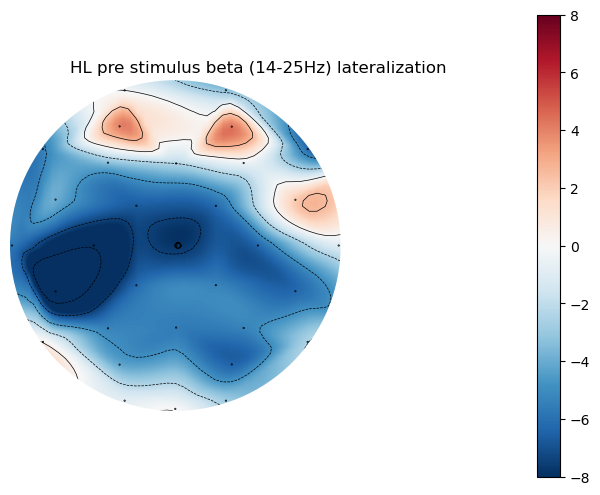

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
im,_ = mne.viz.plot_topomap(HL_avg_right_left_pre, info_pre_picked, vlim=(-8,8), axes=ax, ch_type='eeg',show=False)
plt.title('HL pre stimulus beta (14-25Hz) lateralization')
plt.colorbar(im, ax=ax)
plt.show()

/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/2911187499.py:2: RuntimeWarning: Only 6 head digitization points of the specified kind ("extra",), fitting may be inaccurate
  im,_ = mne.viz.plot_topomap(NH_avg_right_left_pre, info_pre_picked, vlim=(-8,8), axes=ax, ch_type='eeg',show=False)
/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/2911187499.py:2: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size.
  im,_ = mne.viz.plot_topomap(NH_avg_right_left_pre, info_pre_picked, vlim=(-8,8), axes=ax, ch_type='eeg',show=False)


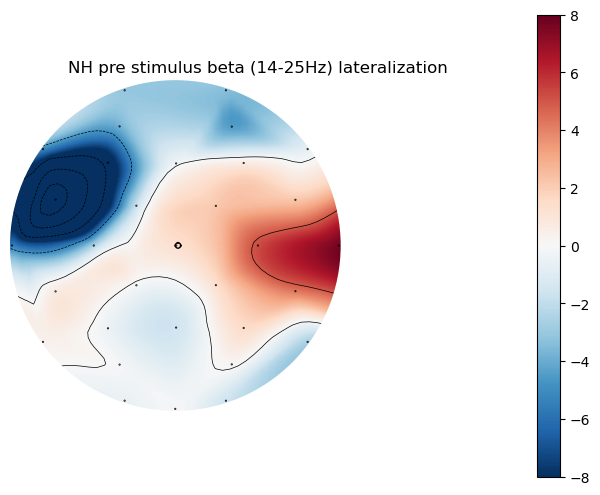

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
im,_ = mne.viz.plot_topomap(NH_avg_right_left_pre, info_pre_picked, vlim=(-8,8), axes=ax, ch_type='eeg',show=False)
plt.title('NH pre stimulus beta (14-25Hz) lateralization')
plt.colorbar(im, ax=ax)
plt.show()

/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/722915434.py:2: RuntimeWarning: Only 6 head digitization points of the specified kind ("extra",), fitting may be inaccurate
  im,_ = mne.viz.plot_topomap(NH_avg_right_left_dur, info_pre_picked, axes=ax, ch_type='eeg',show=False)
/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/722915434.py:2: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size.
  im,_ = mne.viz.plot_topomap(NH_avg_right_left_dur, info_pre_picked, axes=ax, ch_type='eeg',show=False)


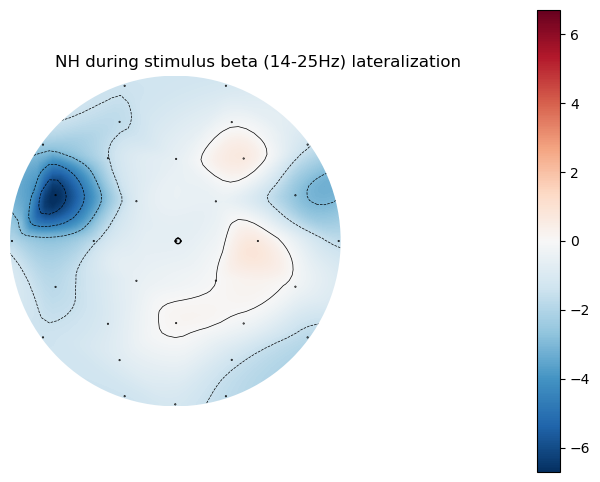

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
im,_ = mne.viz.plot_topomap(NH_avg_right_left_dur, info_pre_picked, axes=ax, ch_type='eeg',show=False)
plt.title('NH during stimulus beta (14-25Hz) lateralization')
plt.colorbar(im, ax=ax)
plt.show()

/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/1189420427.py:2: RuntimeWarning: Only 6 head digitization points of the specified kind ("extra",), fitting may be inaccurate
  im,_ = mne.viz.plot_topomap(HL_avg_right_left_dur, info_pre_picked,  axes=ax, ch_type='eeg',show=False)
/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/1189420427.py:2: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size.
  im,_ = mne.viz.plot_topomap(HL_avg_right_left_dur, info_pre_picked,  axes=ax, ch_type='eeg',show=False)


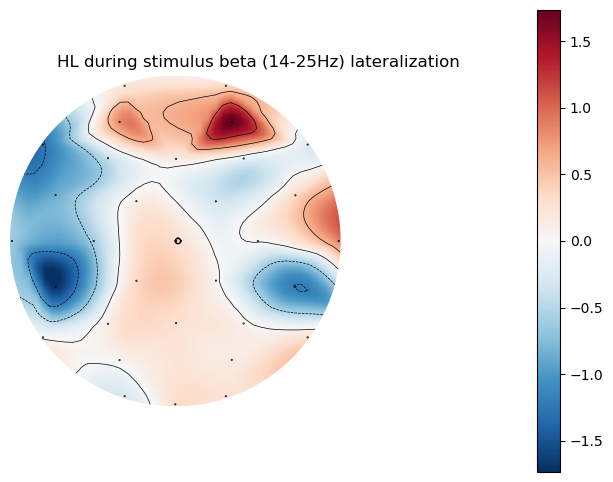

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
im,_ = mne.viz.plot_topomap(HL_avg_right_left_dur, info_pre_picked,  axes=ax, ch_type='eeg',show=False)
plt.title('HL during stimulus beta (14-25Hz) lateralization')
plt.colorbar(im, ax=ax)
plt.show()

## All Subjects - Gamma

In [21]:
fpath = '/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/'
subjects = ['HL002', 'HL004', 'HL005', 'HL008', 'HL010', 'HL007','SP003', 'SP004', 'SP005', 'SP006', 'SP007', 'SP008' , 'HR']
# subjects = ['HR']
HL_subjects = ['HL002', 'HL004', 'HL005', 'HL008', 'HL010', 'HL007']
NH_subjects = ['SP003', 'SP004', 'SP005', 'SP006', 'SP007', 'SP008' , 'HR']

In [22]:
resultsdir = 'results/'


for subj in subjects:
    print(subj)
    lefts = []
    rights = []
    cues = []
    leads = []
    lags= []
    
    channels_to_drop = ['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp']
    
    bdfs = fnmatch.filter(os.listdir(fpath), subj + '_Att*.bdf')
    if subj == 'HR':
        bdfs = ['HR_Attention+006.bdf', 'HR_Attention+007.bdf', 'HR_Attention+005.bdf', 'HR_Attention+004.bdf', 'HR_Attention+008.bdf', 'HR_Attention+003.bdf', 'HR_Attention+002.bdf']
    print(bdfs)
    
    for k, bdf in enumerate(bdfs):
        if bdf == 'HL008_AttentionTask+004.bdf':
            raw, eves = bs.importbdf(bdf, hptsname='biosemi10_20.hpts')
            total = raw.times[-1]
            end_time = total - 120
            raw = raw.crop(tmin=0, tmax=end_time)
        else:
            raw, eves = bs.importbdf(bdf, hptsname='biosemi10_20.hpts')
        print(f'Running file: {bdf}')
        raw.notch_filter(np.arange(60, 241, 60), filter_length='auto', fir_design='firwin')
        raw.filter(1, 40)

        if subj == 'SP004':
            raw.drop_channels(channels_to_drop)

        blinks = find_blinks(raw, ch_name=['Fp1'])
        if subj in ['HR', 'SP004', 'HL004', 'HL010', 'HL007']:
            if k == 0:
                epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                                        reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)
                blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=2)
            
            raw.add_proj(blink_proj)
            raw.apply_proj()
        
        else:
            if k == 0:
                epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                                        reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)
                blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=3)
            
            raw.add_proj(blink_proj)
            raw.del_proj(1)
            raw.apply_proj()

        events_left = [7,8]
        events_left_use = [event_left for event_left in events_left if event_left in eves[:,2]]
    
        events_right = [9,10]
        events_right_use = [event_right for event_right in events_right if event_right in eves[:,2]]

        if events_left_use:
            epochs_left = mne.Epochs(raw, eves, event_id=events_left_use, baseline=(-0.5, 0.0), proj=True,
                        tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))
        lefts.append(epochs_left)
    
        if events_right_use:
            epochs_right = mne.Epochs(raw, eves, event_id=events_right_use, baseline=(-0.5, 0.0), proj=True,
                        tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))
        rights.append(epochs_right)

    if lefts:
        left = concatenate_epochs(lefts)
    if rights:
        right = concatenate_epochs(rights)

    del leads, lags, lefts, rights
    gc.collect()

    del raw, eves
    gc.collect()

    epoch_left_pre = left.copy().crop(tmin=0.4, tmax=1.6)
    epoch_right_pre = right.copy().crop(tmin=0.4, tmax=1.6) 

    epoch_left_dur = left.copy().crop(tmin=2.0, tmax=4.4)
    epoch_right_dur = right.copy().crop(tmin=2.0, tmax=4.4) 
    
    del left, right,

    freqs = np.arange(25., 36., 1.)
    n_cycles = freqs * 0.4

    power_gamma_left_pre = epoch_left_pre.compute_tfr(method="multitaper", freqs=freqs, picks=['eeg'], return_itc=False, n_cycles=n_cycles, average=True)
    power_gamma_right_pre = epoch_right_pre.compute_tfr(method="multitaper", freqs=freqs, picks=['eeg'], return_itc=False, n_cycles=n_cycles, average=True)

    del epoch_left_pre, epoch_right_pre
    
    power_gamma_left_dur = epoch_left_dur.compute_tfr(method="multitaper", freqs=freqs, picks=['eeg'], return_itc=False, n_cycles=n_cycles, average=True)
    power_gamma_right_dur = epoch_right_dur.compute_tfr(method="multitaper", freqs=freqs, picks=['eeg'], return_itc=False, n_cycles=n_cycles, average=True)

    del epoch_left_dur,epoch_right_dur

    avg_power_gamma_left_pre = power_gamma_left_pre.data.mean(axis=1).mean(axis=1)
    avg_power_gamma_right_pre = power_gamma_right_pre.data.mean(axis=1).mean(axis=1)

    avg_power_gamma_left_dur = power_gamma_left_dur.data.mean(axis=1).mean(axis=1)
    avg_power_gamma_right_dur = power_gamma_right_dur.data.mean(axis=1).mean(axis=1)
    
    del power_gamma_left_dur, power_gamma_right_dur, power_gamma_left_pre, power_gamma_right_pre

    norm_avg_power_gamma_right_left_pre = (avg_power_gamma_right_pre - avg_power_gamma_left_pre)/((avg_power_gamma_left_pre + avg_power_gamma_right_pre)*0.5)*100 

    norm_avg_power_gamma_right_left_dur = (avg_power_gamma_right_dur - avg_power_gamma_left_dur)/(avg_power_gamma_left_dur + avg_power_gamma_right_dur)*0.5*100

    fname_left_right_pre = fpath+resultsdir+subj+ '_norm_gamma_right_left_preprestim'
    np.save(fname_left_right_pre, norm_avg_power_gamma_right_left_pre)

    fname_left_right_dur = fpath+resultsdir+subj+ '_norm_gamma_right_left_dur'
    np.save(fname_left_right_dur, norm_avg_power_gamma_right_left_dur)

    del avg_power_gamma_left_pre, avg_power_gamma_right_pre, norm_avg_power_gamma_right_left_pre 
    del avg_power_gamma_left_dur,avg_power_gamma_right_dur, norm_avg_power_gamma_right_left_dur
    gc.collect()

HL002
['HL002_AttentionTask+001.bdf', 'HL002_AttentionTask+003.bdf', 'HL002_AttentionTask+002.bdf', 'HL002_AttentionTask+004.bdf', 'HL002_AttentionTask.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL002_AttentionTask+001.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
119 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: HL002_AttentionTask+001.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Win

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
157 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=92.7%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=2.9%)
Adding projection: eeg-998--0.250-0.250-PCA-03 (exp var=1.5%)
3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items ac

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


SSP projectors applied...
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL002_AttentionTask+003.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
120 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: HL002_Atten

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL002_AttentionTask.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel ty

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   15.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   13.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   27.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   22.0s


HL004
['HL004_AttentionTask+004.bdf', 'HL004_AttentionTask+002.bdf', 'HL004_AttentionTask+003.bdf', 'HL004_AttentionTask+001.bdf', 'HL004_AttentionTask.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL004_AttentionTask+004.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1949695  =      0.000 ...   119.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
20 events found on stim channel Status
Event IDs: [ 5  7  8  9 11]
Running file: HL004_AttentionTask+004.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed t

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=78.6%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=10.0%)
2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
4 match

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
112 events found on stim channel Status
Event IDs: [ 3  5  7  8  9 10 11]
Running file: HL004_AttentionTask+002.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 108135 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   12.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   19.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.1s


HL005
['HL005_AttentionTask+004.bdf', 'HL005_AttentionTask+005.bdf', 'HL005_AttentionTask+001.bdf', 'HL005_AttentionTask+002.bdf', 'HL005_AttentionTask+003.bdf', 'HL005_AttentionTask.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL005_AttentionTask+004.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
91 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: HL005_AttentionTask+004.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
61 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=80.0%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=9.8%)
Adding projection: eeg-998--0.250-0.250-PCA-03 (exp var=4.3%)
3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items act

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


SSP projectors applied...
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL005_AttentionTask+005.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6995967  =      0.000 ...   427.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
62 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: HL005_Attent

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    9.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   17.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   15.6s


HL008
['HL008_AttentionTask.bdf', 'HL008_AttentionTask+004.bdf', 'HL008_AttentionTask+002.bdf', 'HL008_AttentionTask+003.bdf', 'HL008_AttentionTask+001.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL008_AttentionTask.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
72 events found on stim channel Status
Event IDs: [  1   2   3   4   5   7   8   9  10  11 253]
Running file: HL008_AttentionTask.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
163 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['O1']
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=93.2%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=2.2%)
Adding projection: eeg-998--0.250-0.250-PCA-03 (exp var=1.2%)
3 projection i

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


SSP projectors applied...
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL008_AttentionTask+004.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
82 events found on stim channel Status
Event IDs: [ 3  4  5  7  8  9 10 11]
Running file: HL008_Att

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   17.4s


HL010
['HL010_AttentionTask+003.bdf', 'HL010_AttentionTask+002.bdf', 'HL010_AttentionTask+001.bdf', 'HL010_AttentionTask.bdf', 'HL010_AttentionTask+004.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL010_AttentionTask+003.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
91 events found on stim channel Status
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11]
Running file: HL010_AttentionTask+003.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=71.6%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=14.7%)
2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


SSP projectors applied...
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL010_AttentionTask+002.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
90 events found on stim channel Status
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11]
Running file: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   12.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   19.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.1s


HL007
['HL007_AttentionTask+001.bdf', 'HL007_AttentionTask.bdf', 'HL007_AttentionTask+003.bdf', 'HL007_AttentionTask+002.bdf', 'HL007_AttentionTask+005.bdf', 'HL007_AttentionTask+004.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL007_AttentionTask+001.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
96 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: HL007_AttentionTask+001.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
216 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=91.1%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=5.7%)
2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


SSP projectors applied...
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL007_AttentionTask.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
72 events found on stim channel Status
Event IDs: [  2   3   4   5   7   8   9  10  11 253]
Running fil

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL007_AttentionTask+004.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   15.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   12.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   24.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   20.7s


SP003
['SP003_Att+001.bdf', 'SP003_Att+002.bdf', 'SP003_Att+003.bdf', 'SP003_Att+004.bdf', 'SP003_Att+005.bdf', 'SP003_Att.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP003_Att+001.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
103 events found on stim channel Status
Event IDs: [ 5  7  8  9 10 11]
Running file: SP003_Att+001.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
205 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=75.0%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=11.8%)
Adding projection: eeg-998--0.250-0.250-PCA-03 (exp var=6.5%)
3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items a

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


SSP projectors applied...
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP003_Att+002.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
111 events found on stim channel Status
Event IDs: [ 5  7  8  9 10 11]
Running file: SP003_Att+002.bdf
Filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Using data from preloaded Raw for 13 events and 90113 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 19 events and 90113 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 22 events and 90113 original time points ...
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   19.4s


SP004
['SP004_Att.bdf', 'SP004_Att+004.bdf', 'SP004_Att+002.bdf', 'SP004_Att+003.bdf', 'SP004_Att+001.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP004_Att.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7454719  =      0.000 ...   455.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/EEG/lib/python3.9/site-packages/anlffr/helper/biosemi2mne.py:88: RuntimeWarning: DigMontage is only a subset of info. There are 7 channel positions not present in the DigMontage. The channels missing from the montage are:

['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
95 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: SP004_Att.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 108135 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=85.5%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=6.8%)
2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


SSP projectors applied...
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP004_Att+004.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4751359  =      0.000 ...   290.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/EEG/lib/python3.9/site-packages/anlffr/helper/biosemi2mne.py:88: RuntimeWarning: DigMontage is only a subset of info. There are 7 channel positions not present in the DigMontage. The channels missing from the montage are:

['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
50 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: SP004_Att+004.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 108135 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting 

/opt/anaconda3/envs/EEG/lib/python3.9/site-packages/anlffr/helper/biosemi2mne.py:88: RuntimeWarning: DigMontage is only a subset of info. There are 7 channel positions not present in the DigMontage. The channels missing from the montage are:

['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
102 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: SP004_Att+002.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 108135 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

/opt/anaconda3/envs/EEG/lib/python3.9/site-packages/anlffr/helper/biosemi2mne.py:88: RuntimeWarning: DigMontage is only a subset of info. There are 7 channel positions not present in the DigMontage. The channels missing from the montage are:

['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
104 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: SP004_Att+003.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 108135 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

/opt/anaconda3/envs/EEG/lib/python3.9/site-packages/anlffr/helper/biosemi2mne.py:88: RuntimeWarning: DigMontage is only a subset of info. There are 7 channel positions not present in the DigMontage. The channels missing from the montage are:

['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
101 events found on stim channel Status
Event IDs: [ 3  4  5  7  8  9 10 11]
Running file: SP004_Att+001.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 108135 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   10.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   17.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.1s


SP005
['SP005_Att.bdf', 'SP005_Att+001.bdf', 'SP005_Att+003.bdf', 'SP005_Att+002.bdf', 'SP005_Att+004.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP005_Att.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
101 events found on stim channel Status
Event IDs: [ 3  4  5  7  8  9 10 11]
Running file: SP005_Att.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
305 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=91.4%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=3.6%)
Adding projection: eeg-998--0.250-0.250-PCA-03 (exp var=2.8%)
3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s


SSP projectors applied...
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP005_Att+001.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
108 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: SP005_Att+001.bdf
Fil

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   11.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   19.0s


SP006
['SP006_Attentiontask.bdf', 'SP006_Attentiontask+002.bdf', 'SP006_Attentiontask+003.bdf', 'SP006_Attentiontask+001.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP006_Attentiontask.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
111 events found on stim channel Status
Event IDs: [ 3  4  5  7  8  9 10 11]
Running file: SP006_Attentiontask.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) me

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=86.0%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=6.9%)
Adding projection: eeg-998--0.250-0.250-PCA-03 (exp var=2.8%)
3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items act

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


SSP projectors applied...
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP006_Attentiontask+002.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
123 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: SP006_Atten

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   13.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   12.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   19.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.9s


SP007
['SP007_Attentiontask.bdf', 'SP007_Attentiontask+004.bdf', 'SP007_Attentiontask+001.bdf', 'SP007_Attentiontask+002.bdf', 'SP007_Attentiontask+003.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP007_Attentiontask.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
94 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: SP007_Attentiontask.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed tim

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
219 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
    Rejecting  epoch based on EEG : ['FC5']


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=79.1%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=9.5%)
Adding projection: eeg-998--0.250-0.250-PCA-03 (exp var=5.0%)
3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP007_Attentiontask+004.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1933311  =      0.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   10.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   17.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   16.4s


SP008
['SP008_AttentionTask+003.bdf', 'SP008_AttentionTask+002.bdf', 'SP008_AttentionTask+001.bdf', 'SP008_AttentionTask+004.bdf', 'SP008_AttentionTask.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP008_AttentionTask+003.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
109 events found on stim channel Status
Event IDs: [ 3  4  5  7  8  9 10 11]
Running file: SP008_AttentionTask+003.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
109 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=81.6%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=8.6%)
Adding projection: eeg-998--0.250-0.250-PCA-03 (exp var=3.7%)
3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items ac

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


SSP projectors applied...
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/SP008_AttentionTask+002.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
109 events found on stim channel Status
Event IDs: [ 2  4  5  7  8  9 10 11]
Running file: SP008_At

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

3 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   11.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   19.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   19.1s


HR
['HR_Attention+006.bdf', 'HR_Attention+007.bdf', 'HR_Attention+005.bdf', 'HR_Attention+004.bdf', 'HR_Attention+008.bdf', 'HR_Attention+003.bdf', 'HR_Attention+002.bdf']
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HR_Attention+006.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
103 events found on stim channel Status
Event IDs: [ 3  4  5  7  8  9 10 11]
Running file: HR_Attention+006.bdf
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
169 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=90.0%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=3.8%)
2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


SSP projectors applied...
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HR_Attention+007.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
109 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Running file: HR_Attention+007.b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Extracting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   17.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   18.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   29.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   30.7s


### Load data - Gamma

In [23]:
res_fpath = '/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/'
HL_subjects = ['HL002', 'HL004', 'HL005', 'HL008', 'HL010', 'HL007']
NH_subjects = ['SP003', 'SP004', 'SP005', 'SP006', 'SP007', 'SP008' , 'HR']

In [24]:
file = '_norm_gamma_right_left_preprestim.npy'
file_dur = '_norm_gamma_right_left_dur.npy'

HL_sum_right_left_pre = np.zeros(32)
HL_sum_right_left_dur = np.zeros(32)

NH_sum_right_left_pre = np.zeros(32)
NH_sum_right_left_dur = np.zeros(32)

for subj in HL_subjects:
    print(res_fpath+subj+file)
    left_right_pre = np.load(res_fpath+subj+file)
    left_right_dur = np.load(res_fpath+subj+file_dur)
    HL_sum_right_left_pre += left_right_pre
    HL_sum_right_left_dur += left_right_dur
    
HL_avg_right_left_pre = HL_sum_right_left_pre/len(HL_subjects)
HL_avg_right_left_dur = HL_sum_right_left_dur/len(HL_subjects)

/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL002_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL004_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL005_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL008_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL010_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HL007_norm_gamma_right_left_preprestim.npy


In [25]:
for sub in NH_subjects:
    print(res_fpath+sub+file)
    left_right_pre = np.load(res_fpath+sub+file)
    left_right_dur = np.load(res_fpath+sub+file_dur)
    NH_sum_right_left_pre += left_right_pre
    NH_sum_right_left_dur += left_right_dur
    
NH_avg_right_left_pre = NH_sum_right_left_pre/len(NH_subjects)
NH_avg_right_left_dur = NH_sum_right_left_dur/len(NH_subjects)

/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP003_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP004_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP005_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP006_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP007_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/SP008_norm_gamma_right_left_preprestim.npy
/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/results/HR_norm_gamma_

In [26]:
raw, eves = bs.importbdf('/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL004_AttentionTask+001.bdf', hptsname='/Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/biosemi10_20.hpts')
raw.notch_filter(np.arange(60, 241, 60), filter_length='auto', fir_design='firwin')
raw.filter(1, 40)

blinks = find_blinks(raw, ch_name=['Fp1'])
epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                             reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)
blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=3)
raw.add_proj(blink_proj)
raw.del_proj(1)
epochs_left = mne.Epochs(raw, eves, event_id=[7,8], baseline=(-0.5, 0), proj=True,
                        tmin=-0.5, tmax=5, reject=dict(eeg=200e-6))

Extracting EDF parameters from /Users/sharadhib/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Attachments/Attention_EEG/HL004_AttentionTask+001.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8716287  =      0.000 ...   532.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
109 events found on stim channel Status
Event IDs: [ 4  5  7  8  9 10 11]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filte

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 54069 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 360449 samples (22.000 s)

Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-998--0.250-0.250-PCA-01 (exp var=86.6%)
Adding projection: eeg-998--0.250-0.250-PCA-02 (exp var=5.8%)
Adding projection: eeg-998--0.250-0.250-PCA-03 (exp var=2.9%)
3 projection items deactivated
Not setting metadata
19 matching events found
Applying baseline correc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


In [27]:
channels = ['Fp1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3','Pz','PO3',
 'O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4','T8','FC6','FC2','F4','F8','AF4','Fp2','Fz','Cz']

epoch_pre_left = epochs_left.copy().load_data().crop(tmin=0.4, tmax=2.0)
epoch_dur_left = epochs_left.copy().load_data().crop(tmin=2.0, tmax=5.0)

info_pre_picked = mne.pick_info(epochs_left.info, mne.pick_channels(epochs_left.info['ch_names'], include =channels))
info_dur_picked = mne.pick_info(epochs_left.info, mne.pick_channels(epochs_left.info['ch_names'], include =channels))

Using data from preloaded Raw for 19 events and 90113 original time points ...
    Rejecting  epoch based on EEG : ['F3']
1 bad epochs dropped
Using data from preloaded Raw for 19 events and 90113 original time points ...
    Rejecting  epoch based on EEG : ['F3']
1 bad epochs dropped


/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/4239777172.py:2: RuntimeWarning: Only 6 head digitization points of the specified kind ("extra",), fitting may be inaccurate
  im,_ = mne.viz.plot_topomap(HL_avg_right_left_pre, info_pre_picked, axes=ax, ch_type='eeg',show=False)
/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/4239777172.py:2: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size.
  im,_ = mne.viz.plot_topomap(HL_avg_right_left_pre, info_pre_picked, axes=ax, ch_type='eeg',show=False)


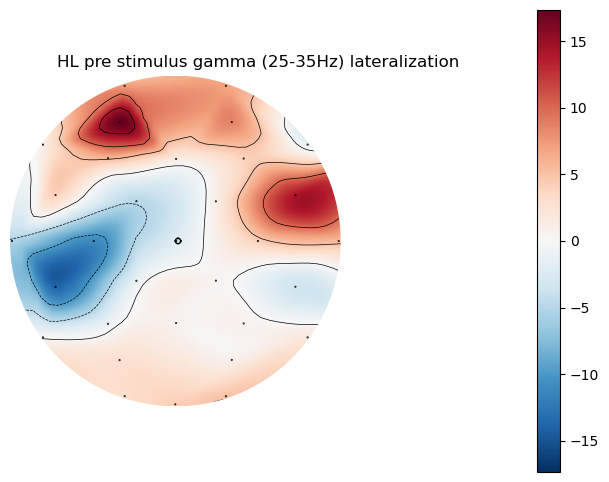

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
im,_ = mne.viz.plot_topomap(HL_avg_right_left_pre, info_pre_picked, axes=ax, ch_type='eeg',show=False)
plt.title('HL pre stimulus gamma (25-35Hz) lateralization')
plt.colorbar(im, ax=ax)
plt.show()

/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/3458977591.py:2: RuntimeWarning: Only 6 head digitization points of the specified kind ("extra",), fitting may be inaccurate
  im,_ = mne.viz.plot_topomap(NH_avg_right_left_pre, info_pre_picked, axes=ax, ch_type='eeg',show=False)
/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/3458977591.py:2: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size.
  im,_ = mne.viz.plot_topomap(NH_avg_right_left_pre, info_pre_picked, axes=ax, ch_type='eeg',show=False)


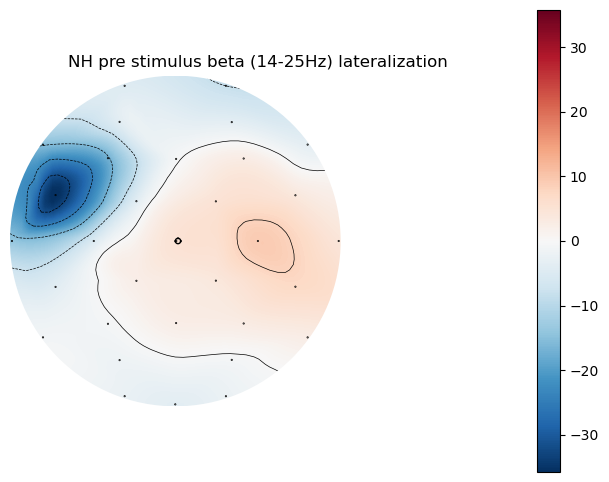

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
im,_ = mne.viz.plot_topomap(NH_avg_right_left_pre, info_pre_picked, axes=ax, ch_type='eeg',show=False)
plt.title('NH pre stimulus beta (14-25Hz) lateralization')
plt.colorbar(im, ax=ax)
plt.show()

/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/722915434.py:2: RuntimeWarning: Only 6 head digitization points of the specified kind ("extra",), fitting may be inaccurate
  im,_ = mne.viz.plot_topomap(NH_avg_right_left_dur, info_pre_picked, axes=ax, ch_type='eeg',show=False)
/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/722915434.py:2: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size.
  im,_ = mne.viz.plot_topomap(NH_avg_right_left_dur, info_pre_picked, axes=ax, ch_type='eeg',show=False)


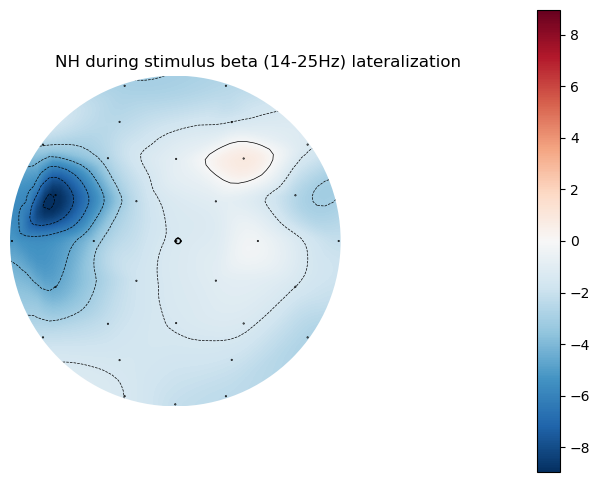

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
im,_ = mne.viz.plot_topomap(NH_avg_right_left_dur, info_pre_picked, axes=ax, ch_type='eeg',show=False)
plt.title('NH during stimulus beta (14-25Hz) lateralization')
plt.colorbar(im, ax=ax)
plt.show()

/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/1189420427.py:2: RuntimeWarning: Only 6 head digitization points of the specified kind ("extra",), fitting may be inaccurate
  im,_ = mne.viz.plot_topomap(HL_avg_right_left_dur, info_pre_picked,  axes=ax, ch_type='eeg',show=False)
/var/folders/j3/th_68nl977j8d8xcjhyl34540000gn/T/ipykernel_40000/1189420427.py:2: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size.
  im,_ = mne.viz.plot_topomap(HL_avg_right_left_dur, info_pre_picked,  axes=ax, ch_type='eeg',show=False)


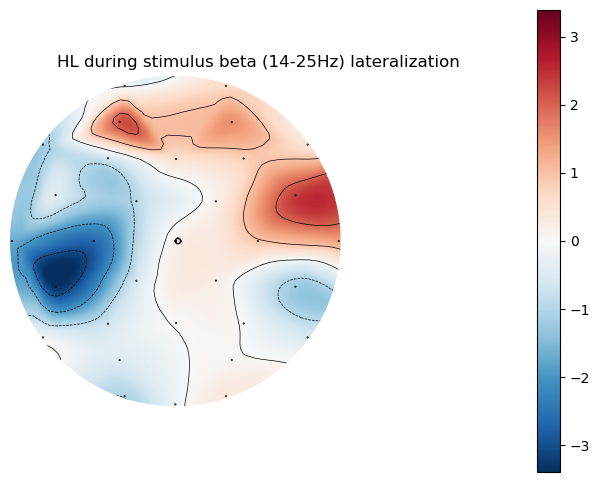

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
im,_ = mne.viz.plot_topomap(HL_avg_right_left_dur, info_pre_picked,  axes=ax, ch_type='eeg',show=False)
plt.title('HL during stimulus beta (14-25Hz) lateralization')
plt.colorbar(im, ax=ax)
plt.show()